# Automated Essay Score Generator

The objective of this code is to generate the automated scores for the given essays. Based on the problem statement, the only parameter to be used is the essay itself and generate the scores. The generated score is then compared with the given score to study the difference. 
This goal can be achieved by first efficiently creating appropriate paramenters which would aid in the scoring, then based on the relatively most significant parameters predicting the scores. It is also very important to choose an appropriate algorithm to predict the scores. Hence, the goal is achieved in 2 parts:
1. Parameter generation
2. Parameter selection and Score prediction

## Parameter generation

Any machine learning algorithm is as good as the data provided to it. Hence, the most important step for this task is to provide appropriate data to the algorithm. It is important to understand that, it is very difficult for any grader to just look at the essay and grade it without any benchmarks. The process is the same for any machine learning algorithm as well. Here, numerical parameters are chosen quantify different benchmarks for the essay. In an attempt to set quantifiable benchmarks to evaluate the essay, following questions are considered :
1. How many words does each essay contain?
2. How many sentences does the essay contain?
3. Does the essay contain multiple paragraphs?
4. What is the average length of a sentence in each essay?
5. How many spelling errors are present in each essay?
6. How many grammatical sentence errors (context based and other basic grammatical checks) does each essay has?

### Code for parameter generation

The first step is to import the necessary modules and libraries

In [8]:
import sys
reload(sys)
sys.setdefaultencoding('utf-8')
import pandas as pd
import nltk
import numpy as np
import re
import grammar_check
import csv
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

Now the next step is to call functions that would be used to process the essay. Also, it is required to create a corpus for spell check at a later point in time 

In [9]:
from nltk.corpus import words
from nltk.corpus import brown
from nltk.corpus import wordnet 
from nltk.stem.wordnet import WordNetLemmatizer
Lem = WordNetLemmatizer()
word_set1 = list(set(wordnet.words())) + list(set(words.words())) + list(set(brown.words()))
word_set = [x.lower() for x in word_set1]
tool = grammar_check.LanguageTool('en-GB')
import string
printable = set(string.printable)

In [10]:
train = pd.read_csv('essay_scoring.csv') #the csv with the essay is loaded

Initializing the parameters

In [11]:
word_cnt = []
sentences = []
avg_sent_length = []
paragraphs = []
spell_errs = []
sent_errs = []
domain_score = []
ess_id = []

Defining the function to pre-process the words in the essay for spell check

In [12]:
def process_word(string):
    string = string.lower()
    for sep in ["'", "/","-","(",")", ",", ".", "!", "?", ";", ":", "\"", " "]:
	string = string.split(sep, 1)[0]
    string = Lem.lemmatize(string)
    return string

Defining the function to split sentences from the given essay

In [13]:
def process_sent(string): 
    string = string.lower()
    string = filter(lambda x: x in printable, string)
    sentence = re.split("\. | \! | \?", string)
    return sentence

Processing each essay to generate the required parameters

In [14]:
for i in range(train.shape[0]): # for each essay
    #preprocessing the essay to ignore non-ascii characters
    ess = train.loc[i][2].decode("ascii", errors="ignore").encode()
    ess_id.append(train.loc[i][1])
    domain_score.append(train.loc[i][5])
    #print 'DS = ', domain_score
        
    #counting number of words 
    wrd_cnt = len(ess.split(" "))
    word_cnt.append(wrd_cnt)
    
    #getting the list of sentences
    sentence = process_sent(ess)
    
    #counting number of sentences
    sent_cnt = len(sentence)
    sentences.append(sent_cnt)
    
    #getting the average sentence length
    avg_sent_len = wrd_cnt/sent_cnt
    avg_sent_length.append(avg_sent_len)
    
    #getting the number of sentence errors
    sent_err_cnt = 0 #initializing sentence error count
    
    for m in sentence:
        try:
            sent_err_cnt+=len(tool.check(m))
        except:
            continue
        
    sent_errs.append(sent_err_cnt)

    #counting number of paragraphs
    prgh_cnt = len(ess.split("\n\n"))
    paragraphs.append(prgh_cnt)

    #getting the number of spelling errors
    err_cnt = 0 #initializing spelling error count
    for j in re.split('\s| ;| ,| \*| \-| \/| \n',ess):
        if j.startswith('@') != True:
            k= process_word(j)
            if k in word_set:
                err_cnt = err_cnt
            else:
                err_cnt +=1
    spell_errs.append(err_cnt)
    
    print 'For essay ', (i+1), 'word count = ', wrd_cnt, 'sentence count = ', sent_cnt, 'avg. sentence length = ', avg_sent_len, \
    'paragraph count = ', prgh_cnt, 'spelling errors = ', err_cnt, 'sentence errors = ', sent_err_cnt
    

KeyboardInterrupt: 

#### Output format:

For essay  1 word count =  338 sentence count =  10 avg. sentence length =  33 paragraph count =  1 spelling errors =  9 sentence errors =  10

For essay  2 word count =  419 sentence count =  18 avg. sentence length =  23 paragraph count =  1 spelling errors =  13 sentence errors =  11

For essay  3 word count =  279 sentence count =  14 avg. sentence length =  19 paragraph count =  1 spelling errors =  2 sentence errors =  10

For essay  4 word count =  524 sentence count =  23 avg. sentence length =  22 paragraph count =  1 spelling errors =  26 sentence errors =  15

For essay  5 word count =  465 sentence count =  30 avg. sentence length =  15 paragraph count =  1 spelling errors =  11 sentence errors =  5


Since, number of paragraphs in all the essays is 1, it is not considered further. 

In [ ]:
with open('parameters.csv', 'wb') as f:
	writer = csv.writer(f)
	for val in zip(['domain1_score']+domain_score, ['essay_set']+ess_id,['words_count']+word_cnt, ['sentence_count']+sentences, ['avg_sentence_length']+avg_sent_length, ['total_spelling_errors']+spell_errs, ['total_sentence_errors']+ sent_errs):
		writer.writerow(val)	

Now since the generating parameters take a lot of time, it is required to store them in the csv file for further usage. The next section deals with selecting appropriate model for predicting the score.

## Generating the predicted scores

The following code uses gradient tree boosting regressor to predict the scores since it has been proved to perform well against relatively smaller dataset with fewer parameters. It also allows for the testing of the significance of the chosen parameters in predicting the final output.

For the first step we import required modules and libraries.

In [20]:
import numpy as np
import pandas as pd
import random
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

The next step is to load the parameters.

In [21]:
df = pd.read_csv('parameters.csv')
df = df.fillna(0) 

Defining the training and testing parameters. And then dividing the data into training and testing sets.

In [22]:
X = df[['essay_set','words_count', 'sentence_count', 'avg_sentence_length', 'total_spelling_errors', 'total_sentence_errors']]
Y = df['domain1_score']
rows = random.sample(df.index, int(len(df)*.80))
x_train, y_train = X.ix[rows],Y.ix[rows]
x_test,y_test  = X.drop(rows),Y.drop(rows)

Defining the parameters for the regressor and then for fitting the model 500 trees with each tree having a depth of 6 levels is selected. Also, huber loss is considered as it is less sensitive to outliers in data than the squared error loss.

In [30]:
params = {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.1, 'loss': 'huber','alpha':0.95}
clf = GradientBoostingRegressor(**params).fit(x_train, y_train)

Once the model is fitted, the next step is to check if the parameters selected are significantly contributing towards the final prediction. Hence, the relative significant scores are evaluated using below snippet.

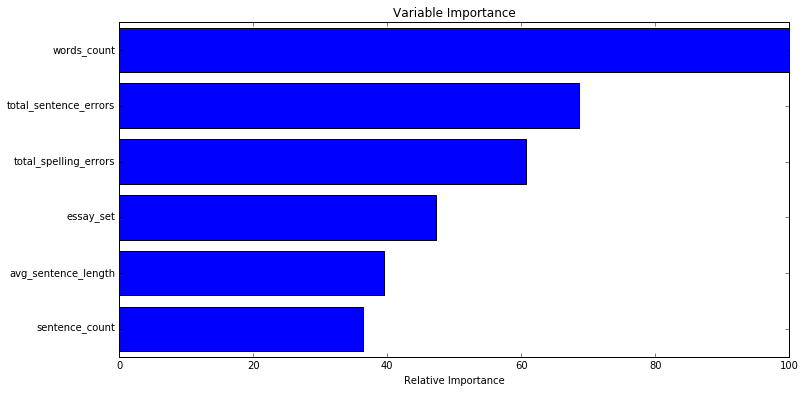

In [31]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It can be observed that all the chosen parametrs contribute significantly towards the final predicted score for each essay. Hence, it was decided to retain all the parameters. It is worth noting that, due to initial round of inspection paragraph count was excluded from the list of parameters. If it was missed during the inspection, it whould be evident from the above snippet to exclude such parameters.

To assess the goodness of the fit, the MSE and the R-Squared scores are computed.

In [25]:
mse = mean_squared_error(y_test, clf.predict(x_test))
r2 = r2_score(y_test, clf.predict(x_test))
print("MSE: %.4f" % mse)
print("R2: %.4f" % r2)

The model achieves a decent performance in predicting the final score for the essay with the MSE score of around 3 and R-Squared score of higher 90%.